# Three-Body Problem
### Flora Hess (flora.hess@stud.uni-heidelberg.de)<br/>Leonardo K. Reiter (leonardo.reiter@stud.uni-heidelberg.de)<br/>Jason G. Jun (jun.jasongabriel@stud.uni-heidelberg.de)
In case the Plots seem to small please double click. Thank you.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.special import gamma
%matplotlib inline

plt.rcParams["figure.figsize"] = 16, 16
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.grid"] = True
# plt.rcParams["figure.subplot.hspace"] = 0

The excercise is, to adapt the Runge-Kutta-4 integrator to the gravitational 3-body problem.

The differential equation for the second derivative is the following: 

$$ \ddot{x_i}=-Gm_j\frac{x_i-x_j}{|x_i-x_j|^3}-Gm_k\frac{x_i-x_k}{|x_i-x_k|^3}$$

We set $G=1$.

In [2]:
def rk4_step(y0, x0, f, h, f_args = {}):
    k1 = h * f(y0, x0, **f_args)
    k2 = h * f(y0 + k1/2., x0 + h/2., **f_args)
    k3 = h * f(y0 + k2/2., x0 + h/2., **f_args)
    k4 = h * f(y0 + k3, x0 + h, **f_args)
    xp1 = x0 + h
    yp1 = y0 + 1./6.*(k1 + 2.*k2 + 2.*k3 + k4)
    return(yp1,xp1)

def rk4(y0, x0, f, h, n, f_args = {}):
    yn = np.zeros((n+1, y0.shape[0]))
    xn = np.zeros(n+1)
    yn[0,:] = y0
    xn[0] = x0
    for n in np.arange(1,n+1,1):
        yn[n,:], xn[n] = rk4_step(yn[n-1,:], xn[n-1], f, h, f_args)
    return (yn, xn)

def f(y, x, m1, m2, m3):
    dydx = np.zeros(12)
    m = [m1, m2, m3]
    for i in range(3):
        n = i*4
        for j in range(2):
            dydx[n+j] = y[n+j+2]
            dydx[n+j+2] = -m[(i+1)%3]*(y[n+j]-y[(n+4)%12+j])*((y[n]-y[(n+4)%12])**2+(y[n+1]-y[(n+4)%12+1])**2)**(-3/2)\
                          -m[(i+2)%3]*(y[n+j]-y[(n+8)%12+j])*((y[n]-y[(n+8)%12])**2+(y[n+1]-y[(n+8)%12+1])**2)**(-3/2)
    return dydx

def plot_tbp(x, y):
    fig, ax = plt.subplots(1)
    for i in range(3):
        ax.plot(y[:, i*4], y[:, i*4+1], label=f"$m_{i}$")
        ax.scatter(y[:, i*4][0], y[:, i*4+1][0])
    ax.set_title("Three-Body Problem with 4th Order Runge-Kutta Method")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.legend()
    plt.show()
    
def plot_tbp2(x, y, r, E, x_mins, r_mins, h):
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    for i in range(3):
        ax1.plot(y[:, 4*i], y[:, 4*i+1])
        ax1.scatter(y[:, 4*i][0], y[:, 4*i+1][0])
    ax2.plot(x, r)
    ax2.scatter(x_mins, r_mins, c="red")
    ax3.plot(x, 1-E/E[0])
    ax1.set_ylabel("y")
    ax1.set_xlabel("x")
    ax1.set_title("Trajectories")
    ax2.set_ylabel("r")
    ax2.set_xlabel("t")
    ax2.set_title("Relative Distances")
    ax3.set_ylabel("E")
    ax3.set_xlabel("t")
    ax3.set_title("Relative Energy Deviation")
    ax2.set_yscale("log")
    ax3.set_yscale("log")
    ax1.legend(("$m_1$", "$m_2$", "$m_3$"))
    ax2.legend(("$r_{12}$", "$r_{23}$", "$r_{31}$", f"{len(x_mins)} Minima"))
    fig.suptitle(f"Three-Body Problem with 4th Order Runge-Kutta Method\n for Time Step $h = 10^{ {int(np.log10(h))}}$")
    fig.tight_layout()
    fig.subplots_adjust(top=0.85) 
    plt.show()

def calc_distances(y):
    r = np.zeros((len(y),3))
    for i in range(len(y)):
        for j in range(3):
            r[i, j] = ( (y[i, j*4] - y[i, (j*4+4)%12])**2 + (y[i, j*4+1] - y[i, (j*4+4)%12+1])**2 )**(1/2)
    return r

def find_minima(r, x):
    x_mins = []
    r_mins = []
    for i in range(1, len(r)-1):
        for j in range(3):            
            condition = r[i, j] < r[i+1, j] and r[i, j] < r[i-1, j]
            if condition:
                x_mins.append(x[i])
                r_mins.append(r[i, j])
    return np.array(x_mins), np.array(r_mins)

def calc_energy(y, m1, m2, m3):
    E = np.zeros(y.shape[0])
    m = [m1, m2, m3]
    for i in range(len(E)):
        for j in range(3):
            n = j*4
            E[i] += - m[j]*m[(j+1)%3]*((y[i,n]-y[i,(n+4)%12])**2+(y[i,n+1]-y[i,(n+4)%12+1])**2)**(-1/2)\
                    + m[j]*(y[i,n+2]**2+y[i,n+3]**2)
    return E

def infinity(h):
    y0 = np.array([+0.97000436,-0.24308753,
                   -0.46620368,-0.43236573,
                   -0.00000000,+0.00000000,
                   +0.93240737,+0.86473146,
                   -0.97000436,+0.24308753,
                   -0.46620368,-0.43236573])
    x0 = 0
    f_args = {"m1": 1, "m2": 1, "m3": 1}
    n = int(2/h)
    y, x = rk4(y0, x0, f, h, n, f_args)
    r = calc_distances(y)
    plot_tbp(x, y)

def meisselburrau(x0, y0, f_args, h, T=4):
    n = int(T/h)
    y, x = rk4(y0, x0, f, h, n, f_args)
    r, E = calc_distances(y), calc_energy(y, **f_args)
    x_mins, r_mins = find_minima(r, x)
    np.savetxt(f"x_mins_{-int(np.log10(h))}.csv", x_mins, delimiter=",")
    plot_tbp2(x, y, r, E, x_mins, r_mins, h)

### (a) Infinity Loop

We want to calculate the trajectory of the three bodies. Therefore we set the masses of all three bodies to $m_{1}=m_{2}=m_{3}=1$ and select the following initial conditions for $y(0)$:
$$
\begin{array}{rlrl}
\left(y_{1}, y_{2}\right) & = & 0.97000436 & -0.24308753 \\
\left(y_{3}, y_{4}\right) & = & -0.46620368 & -0.43236573 \\
\left(y_{5}, y_{6}\right) & = & 0.0 & 0.0 \\
\left(y_{7}, y_{8}\right) & = & 0.93240737 & 0.86473146 \\
\left(y_{9}, y_{10}\right) & = & -0.97000436 & 0.24308753 \\
\left(y_{11}, y_{12}\right) & = & -0.46620368 & -0.43236573
\end{array}
$$

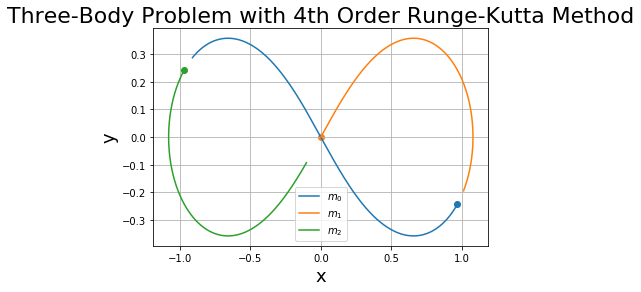

In [3]:
h = 1e-3
infinity(h)

### (b) Meissel-Burrau Problem

Now we consider the so called Meissel-Burrau problem. We choose the masses of the three bodies to be $m_{1}=5, m_{2}=4$ and $m_{3}=3$.


We use the Runge-Kutta-4 integrator to follow the time evolution of the system until it dissolves. The plots show  the trajectories of the three bodies in the orbital plane, the mutual distances of the three bodies in logarithmic scaling and the error of the total energy of the system in logarithmic scaling as function of time.

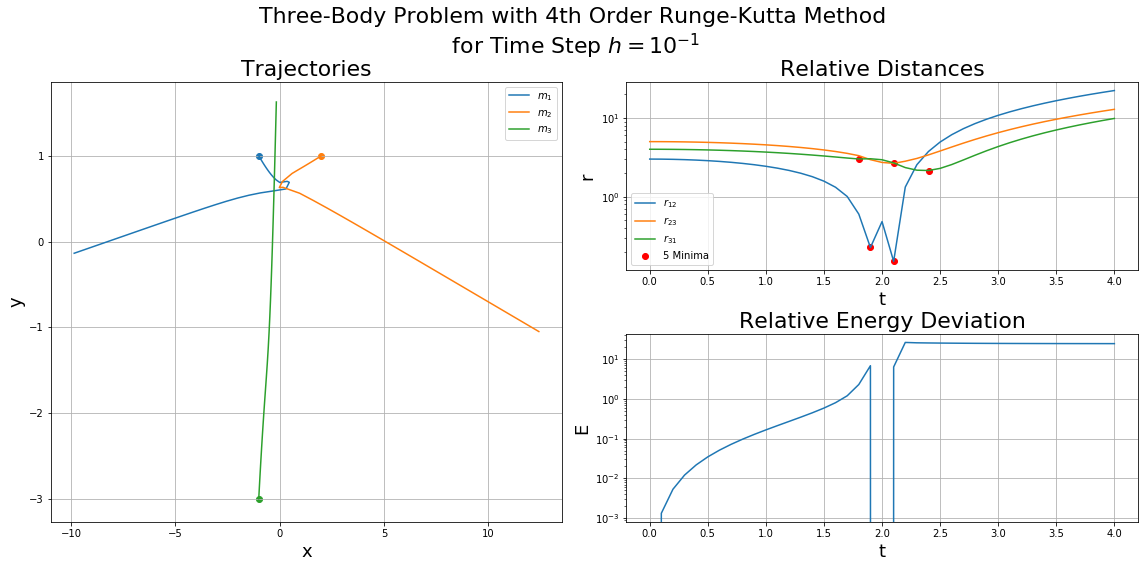

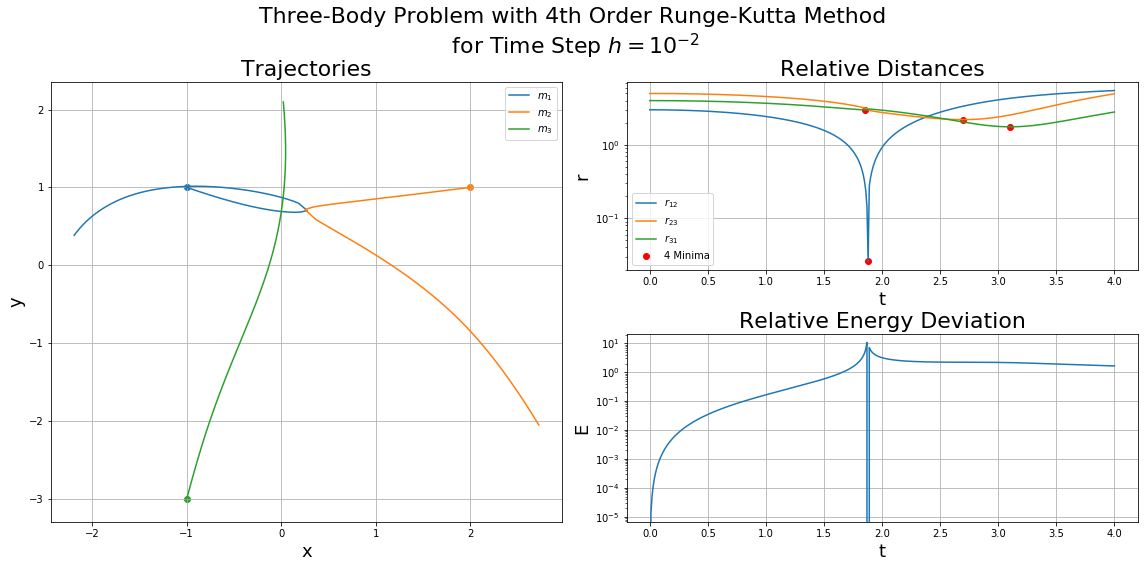

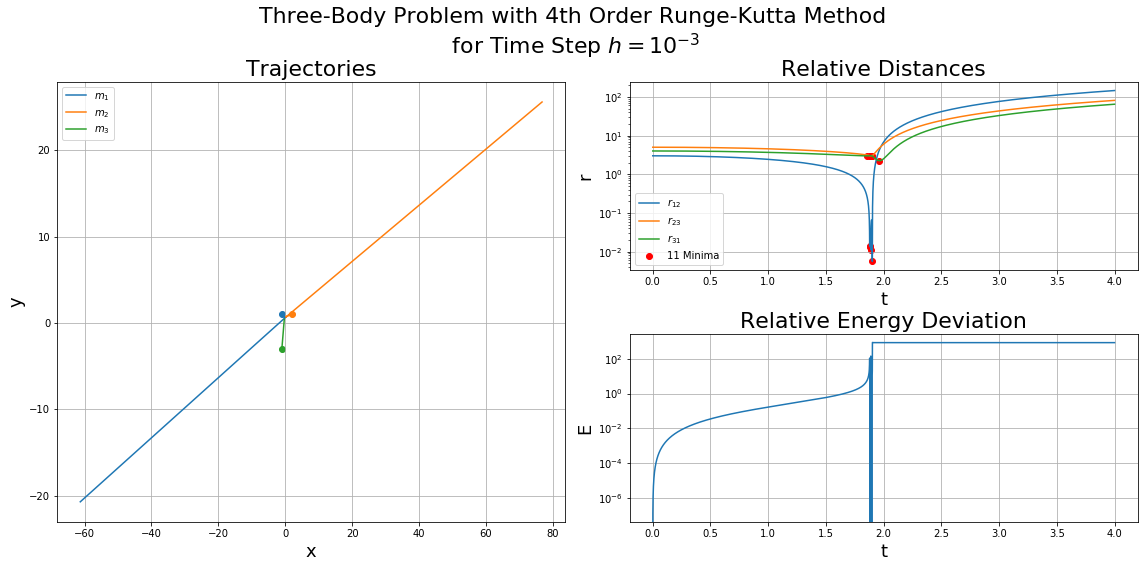

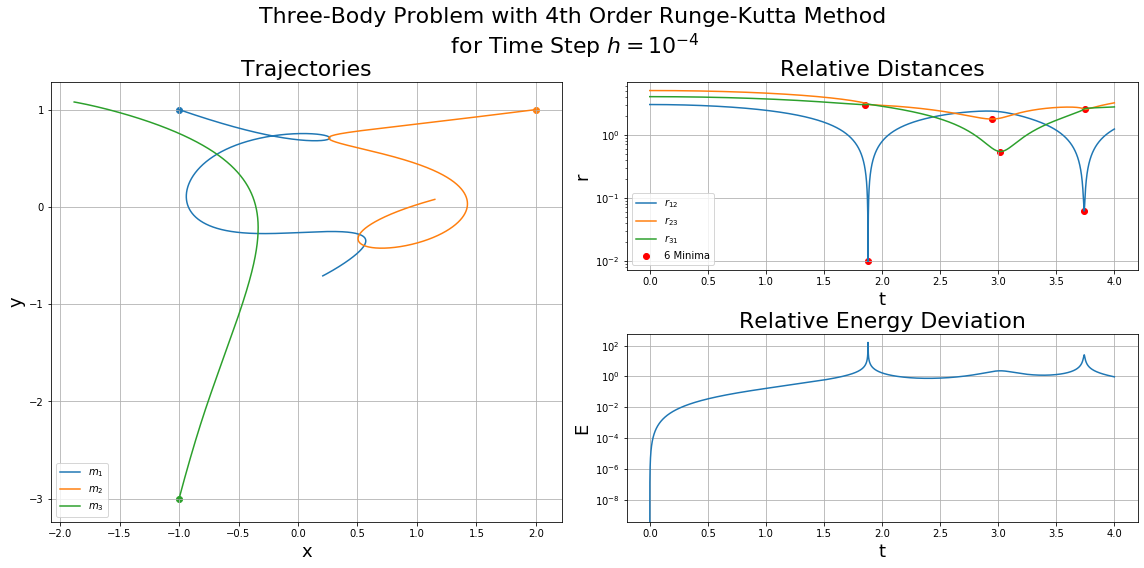

In [4]:
y0 = np.array([-1,+1,
               +0,+0,
               +2,+1,
               +0,+0,
               -1,-3,
               +0,+0])
x0 = 0
f_args = {"m1": 5, "m2": 4, "m3": 3}
h_min = 4
for h in np.logspace(-1, -h_min, h_min):
    meisselburrau(x0, y0, f_args, h)

### (c) Further Study

We use the same initial configuration as in (b), but now add an initial velocity of $v=0.1$ to the most massive particle $\left(m_{1}=5\right)$ in the direction towards the body $m_{2}=4 .$ The trajectories of the three bodies are studied for the same values of $h$ as before.


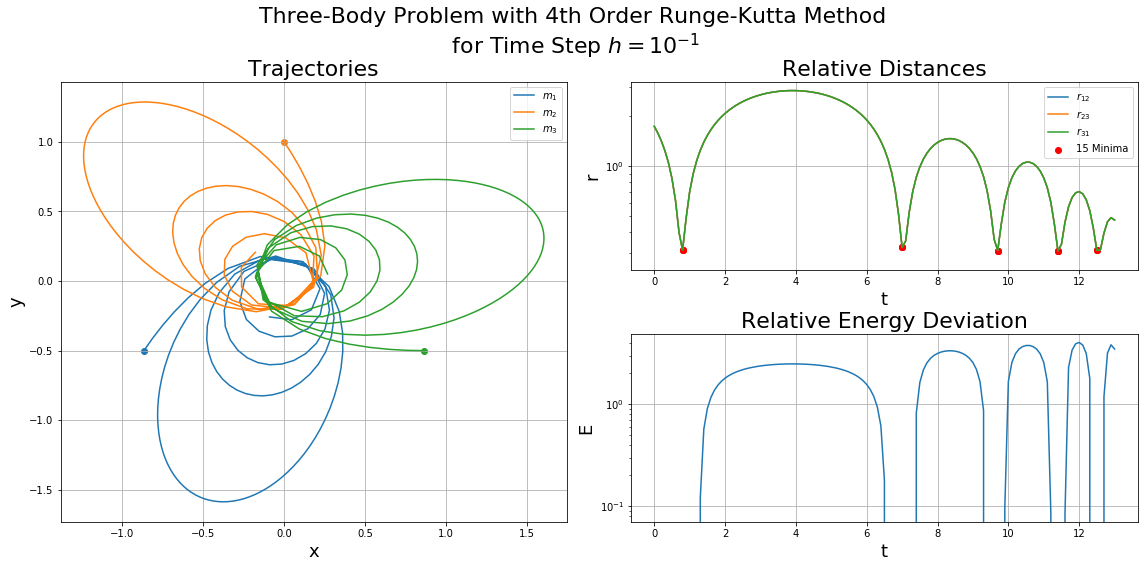

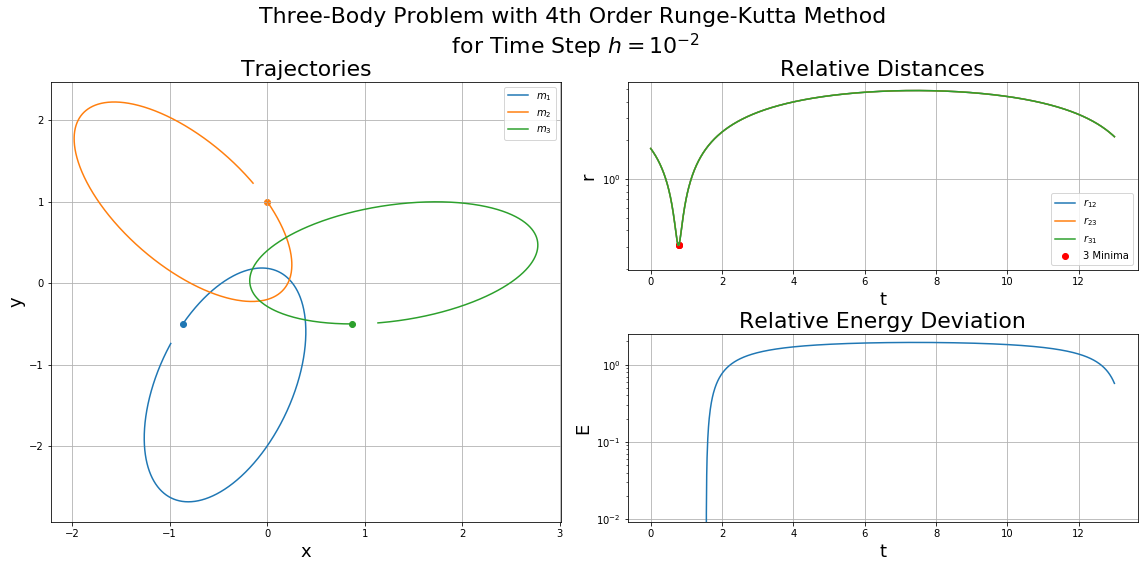

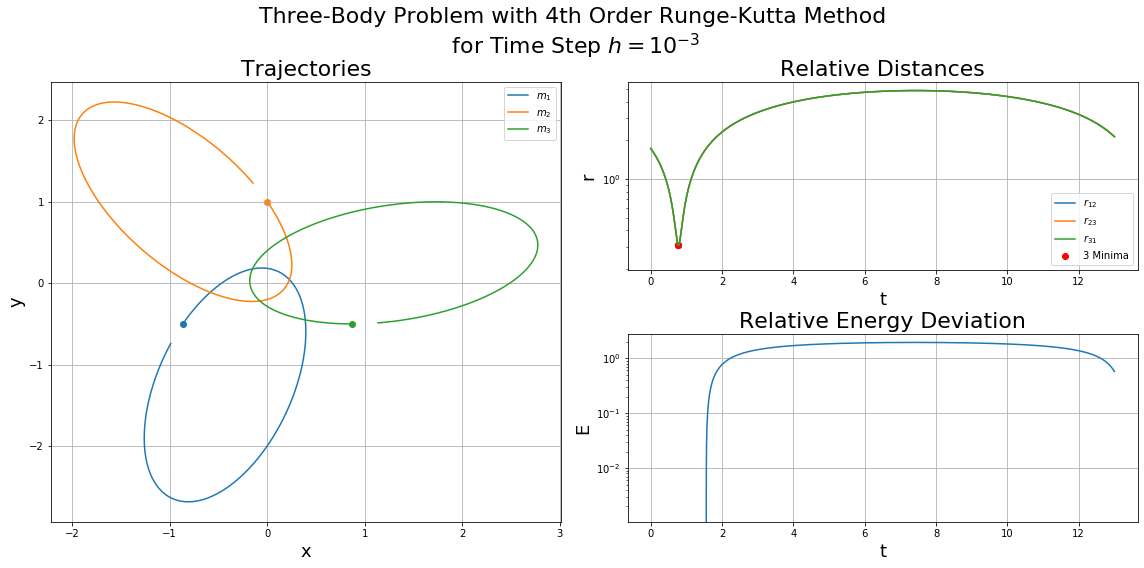

In [5]:
tilt = -60
phi = np.pi/2 - np.pi/180*tilt
y0 = np.array([np.sin(-2/3*np.pi    ),np.cos(-2/3*np.pi    ),
               np.sin(-2/3*np.pi+phi),np.cos(-2/3*np.pi+phi),
               np.sin(+0            ),np.cos(+0            ),
               np.sin(+0        +phi),np.cos(+0        +phi),
               np.sin(+2/3*np.pi    ),np.cos(+2/3*np.pi    ),
               np.sin(+2/3*np.pi+phi),np.cos(+2/3*np.pi+phi)])
x0 = 0
m = 1.3
f_args = {"m1": m, "m2": m, "m3": m}
h_min = 3
T = 13
for h in np.logspace(-1, -h_min, h_min):
    meisselburrau(x0, y0, f_args, h, T)